In [28]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
#from bayes_opt import BayesianOptimization
from bayes_opt import BayesianOptimization



In [29]:
# Load the data from UCI repository
train = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
test = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows=1, header=None)

In [30]:
# Define column labels
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage_class']

train.columns = col_labels
test.columns = col_labels

In [31]:
# Convert target variable to binary
encoder = LabelEncoder()
train['wage_class'] = encoder.fit_transform(train['wage_class'])

In [32]:
# Define categorical and numerical features
numerical_features = [feature for feature in train.columns if train[feature].dtype != 'O']
categorical_features = [feature for feature in train.columns if train[feature].dtype == 'O' and feature != 'wage_class']

In [33]:
# Transform 'native_country' feature to be 1 if country is the United States, otherwise 0
train['native_country'] = np.where(train['native_country'] == ' United-States', 1, 0)

# Transform 'marital_status' and concatenate some classes to reduce distinct classes
train['marital_status'] = train['marital_status'].replace({' Married-civ-spouse': 'Married', ' Never-married': 'Single',
                                                           ' Separated': 'Divorced', ' Married-spouse-absent': 'Divorced',
                                                           ' Divorced': 'Divorced', ' Married-AF-spouse': 'Divorced', ' Widowed': 'Widowed'})

In [34]:
# Transform 'workclass' feature to be 1 if the workclass is Private and 0 otherwise
train['workclass'] = np.where(train['workclass'] == ' Private', 1, 0)

# Transform 'sex' feature to be 1 if the sex is Male and 0 otherwise
train['sex'] = np.where(train['sex'] == ' Male', 1, 0)

# Transform 'race' feature to be 1 if the race is White and 0 otherwise
train['race'] = np.where(train['race'] == ' White', 1, 0)

In [35]:
# Create ordered label for education
education_mapping = {' Preschool': 0, ' 1st-4th': 1, ' 5th-6th': 2, ' 7th-8th': 3, ' 9th': 4, ' 10th': 5,
                     ' 11th': 6, ' 12th': 7, ' HS-grad': 8, ' Some-college': 0, ' Assoc-acdm': 10,
                     ' Assoc-voc': 11, ' Bachelors': 12, ' Prof-school': 13, ' Masters': 14, ' Doctorate': 15}
train['education'] = train['education'].map(education_mapping)

In [36]:
# Map ordered labels for 'relationship', 'occupation', and 'marital_status' features
relationship_ordered = train.groupby(['relationship'])['wage_class'].count().sort_values().index
relationship_ordered = {k: i for i, k in enumerate(relationship_ordered, 0)}
train['relationship'] = train['relationship'].map(relationship_ordered)

occupation_ordered = train.groupby(['occupation'])['wage_class'].count().sort_values().index
occupation_ordered = {k: i for i, k in enumerate(occupation_ordered, 0)}
train['occupation'] = train['occupation'].map(occupation_ordered)

marital_ordered = train.groupby(['marital_status'])['wage_class'].count().sort_values().index
marital_ordered = {k: i for i, k in enumerate(marital_ordered, 0)}
train['marital_status'] = train['marital_status'].map(marital_ordered)

In [37]:
# Drop 'fnlwgt' column as it's not useful for prediction
train.drop('fnlwgt', axis=1, inplace=True)

In [38]:
# Scale the features
scaler = StandardScaler()
scaled_features_train = scaler.fit_transform(train.drop('wage_class', axis=1))
scaled_features_train = pd.DataFrame(scaled_features_train, columns=train.drop('wage_class', axis=1).columns)

In [39]:
# Undersample the train set
under = OneSidedSelection()
X_train_res, y_train_res = under.fit_resample(scaled_features_train, train['wage_class'])

# Oversample the train set
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train_res, y_train_res)
X_train_res = pd.DataFrame(X_train_res, columns=train.drop('wage_class', axis=1).columns)

# Create the final train set
final_train = pd.concat([X_train_res, y_train_res], axis=1)

In [40]:
# Split the final train set into features and target
X = final_train.drop('wage_class', axis=1)
y = final_train['wage_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [41]:
# Define the XGBoost model with Bayesian Optimization for hyperparameter tuning
def xgb_evaluate(max_depth, gamma, colsample_bytree, min_child_weight):
    params = {'eval_metric': 'logloss',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              'min_child_weight': min_child_weight}

    model = xgb.XGBClassifier(use_label_encoder=False, **params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return accuracy_score(y_test, predictions)

# Define the parameter space for Bayesian Optimization
xgb_params = {'max_depth': (3, 7),
              'gamma': (0, 1),
              'colsample_bytree': (0.3, 0.9),
              'min_child_weight': (1, 10)}

In [42]:
# Apply Bayesian Optimization
xgb_bo = BayesianOptimization(xgb_evaluate, xgb_params, random_state=0)
xgb_bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... |
-------------------------------------------------------------------------


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 1         | 0.8876    | 0.6293    | 0.7152    | 5.411     | 5.904     |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 2         | 0.8764    | 0.5542    | 0.6459    | 4.75      | 9.026     |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 3         | 0.8932    | 0.8782    | 0.3834    | 6.167     | 5.76      |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 4         | 0.8664    | 0.6408    | 0.9256    | 3.284     | 1.784     |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 5         | 0.894     | 0.3121    | 0.8326    | 6.113     | 8.83      |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 6         | 0.8947    | 0.3       | 0.8424    | 6.76      | 8.194     |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 7         | 0.8915    | 0.6252    | 0.15      | 6.942     | 9.992     |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 8         | 0.9003    | 0.3       | 0.0       | 7.0       | 4.081     |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 9         | 0.8984    | 0.9       | 1.0       | 7.0       | 2.875     |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 10        | 0.9011    | 0.3       | 0.0       | 7.0       | 1.074     |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 11        | 0.9001    | 0.3       | 0.0       | 7.0       | 2.478     |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 12        | 0.8992    | 0.3       | 1.0       | 7.0       | 4.895     |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 13        | 0.9003    | 0.3       | 1.0       | 7.0       | 1.0       |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 14        | 0.8934    | 0.9       | 0.0       | 6.21      | 1.0       |


C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


| 15        | 0.8985    | 0.3       | 0.0       | 7.0       | 5.886     |


In [43]:
# Get the best parameters
best_params = xgb_bo.max['params']
best_params['max_depth'] = int(best_params['max_depth'])


In [44]:
# Train the XGBoost model with the best parameters
xgb_model = xgb.XGBClassifier(use_label_encoder=False, **best_params)
xgb_model.fit(X_train, y_train)

C:\Users\Fahad Shahid\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1.0741307680980723, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [45]:
# Make predictions on the test set
test_predictions = xgb_model.predict(X_test)

In [46]:
# Evaluate the model
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Set Accuracy (XGBoost): {test_accuracy}")

Test Set Accuracy (XGBoost): 0.9120507399577167


In [47]:
# Get feature importances from the model
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns


In [48]:
# Create a pandas Series to hold the feature importances and names, and sort it
importances_series = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

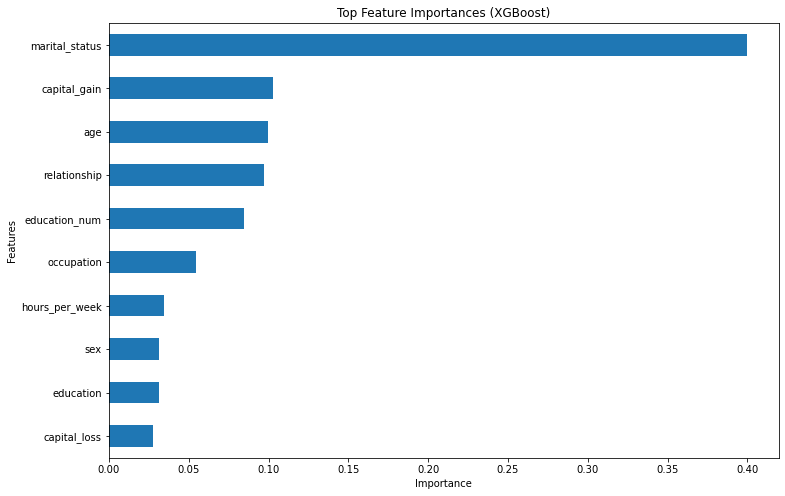

In [49]:
# Plot the top feature importances
plt.figure(figsize=(12, 8))
importances_series[:10].plot(kind='barh')
plt.title('Top Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()

In [50]:
# Make predictions on the test set with probabilities
test_probabilities = xgb_model.predict_proba (X_test) [:, 1]

In [51]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, test_probabilities)

print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.9748354775224988


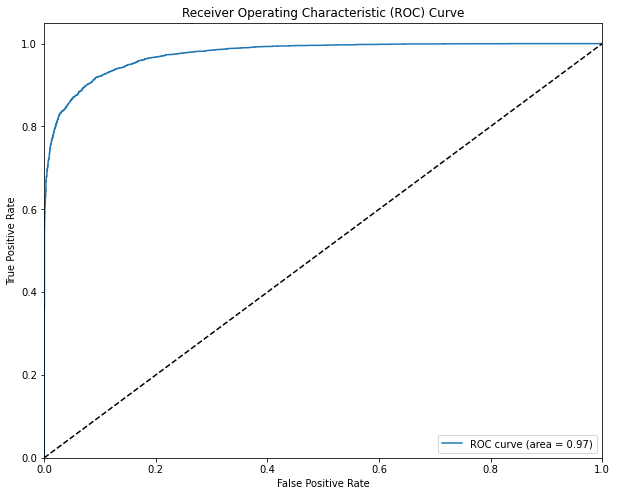

In [52]:
# Plot ROC curve
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()